# Тестовое задание Revo:Mokka

В файле revo_ds_test_task.csv собраны данные по повторным займам текущих клиентов компании.

По имеющемуся набору данных, необходимо построить модель, которая будет прогнозировать значение целевой переменной 'bad_flag'.

In [203]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier

import xgboost as Xgb

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch.nn import functional as F

### EDA и первичная обработка данных

In [204]:
df = pd.read_csv('revo_ds_test_task.csv')
df.head()

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
0,708382,2016-10-06,2015-11-13,NaN,NaN,NaN,NaN,3.0,region_6,6,...,10,0,0,0,10.0,NaN,NaN,21.0,False,0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,...,6,0,0,0,5.0,NaN,NaN,20.0,False,0
2,779736,2016-10-30,2015-12-21,NaN,NaN,NaN,NaN,2.0,region_1,6,...,0,5,0,0,5.0,NaN,NaN,19.0,False,0
3,556376,2016-06-29,2015-06-30,NaN,NaN,NaN,NaN,1.0,region_6,14,...,4,0,0,0,6.0,NaN,NaN,21.0,False,0
4,266968,2015-12-01,2015-08-03,NaN,NaN,NaN,NaN,0.0,region_5,22,...,0,0,0,0,3.0,NaN,NaN,33.0,False,0


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loanKey              4157 non-null   int64  
 1   rep_loan_date        4157 non-null   object 
 2   first_loan           4157 non-null   object 
 3   dpd_5_cnt            675 non-null    float64
 4   dpd_15_cnt           675 non-null    float64
 5   dpd_30_cnt           675 non-null    float64
 6   first_overdue_date   675 non-null    object 
 7   close_loans_cnt      4142 non-null   float64
 8   federal_district_nm  4146 non-null   object 
 9   TraderKey            4157 non-null   int64  
 10  payment_type_0       4157 non-null   int64  
 11  payment_type_1       4157 non-null   int64  
 12  payment_type_2       4157 non-null   int64  
 13  payment_type_3       4157 non-null   int64  
 14  payment_type_4       4157 non-null   int64  
 15  payment_type_5       4157 non-null   i

In [206]:
df.describe()

,loanKey,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,bad_flag
count,4157.000000,675.000000,675.000000,675.000000,4142.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.0,3909.000000,3507.000000,239.000000,4157.000000,4157.000000
mean,525386.651431,1.444444,0.733333,0.280000,1.184693,12.338225,0.018523,0.596103,3.755834,0.758239,0.019485,0.0,4.979023,578.911345,552.546610,34.561222,0.100313
std,202001.338206,0.900599,0.764572,0.502339,1.723715,9.902927,0.330359,2.564887,3.810703,2.212487,0.245960,0.0,3.491556,48.989869,21.492840,10.834143,0.300453
min,58567.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,384.220628,485.874267,18.000000,0.000000
25%,363964.000000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,2.000000,547.429791,535.545724,26.000000,0.000000
50%,543603.000000,1.000000,1.000000,0.000000,1.000000,6.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,4.000000,588.531315,556.757944,32.000000,0.000000
75%,687271.000000,2.000000,1.000000,1.000000,2.000000,14.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.0,6.000000,612.323090,567.608057,41.000000,0.000000
max,884377.000000,7.000000,5.000000,3.000000,31.000000,80.000000,15.000000,81.000000,33.000000,35.000000,7.000000,0.0,21.000000,691.528420,603.311653,74.000000,1.000000


In [207]:
df.isnull().sum()

loanKey                   0
rep_loan_date             0
first_loan                0
dpd_5_cnt              3482
dpd_15_cnt             3482
dpd_30_cnt             3482
first_overdue_date     3482
close_loans_cnt          15
federal_district_nm      11
TraderKey                 0
payment_type_0            0
payment_type_1            0
payment_type_2            0
payment_type_3            0
payment_type_4            0
payment_type_5            0
past_billings_cnt       248
score_1                 650
score_2                3918
age                       0
gender                    0
bad_flag                  0
dtype: int64

In [208]:
# обработка признака 0 (loanKey - идентификатор повторного займа)
df[df['loanKey'].duplicated() == True]

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag


In [209]:
# обработка признака 1 (rep_loan_date - дата повторного займа)
df['rep_loan_date'] = pd.to_datetime(df['rep_loan_date'], format='%Y-%m-%d')
df['rep_loan_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4157 entries, 0 to 4156
Series name: rep_loan_date
Non-Null Count  Dtype         
--------------  -----         
4157 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 32.6 KB


In [210]:
   # создание признаков: год повторного займа, месяц повторного займа, день повторного займа
df['rep_loan_year']= df['rep_loan_date'].apply(lambda x: x.year).astype(int)
df['rep_loan_month'] = df['rep_loan_date'].apply(lambda x: x.month).astype(int)
df['rep_loan_day'] = df['rep_loan_date'].apply(lambda x: x.day).astype(int)

In [211]:
# обработка признака 2 (first_loan - дата первого займа)
df['first_loan'] = pd.to_datetime(df['first_loan'], format='%Y-%m-%d')
df['first_loan'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4157 entries, 0 to 4156
Series name: first_loan
Non-Null Count  Dtype         
--------------  -----         
4157 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 32.6 KB


In [212]:
   # создание признаков: год первого займа, месяц первого займа, день первого займа
df['first_loan_year']= df['first_loan'].apply(lambda x: x.year).astype(int)
df['first_loan_month'] = df['first_loan'].apply(lambda x: x.month).astype(int)
df['first_loan_day'] = df['first_loan'].apply(lambda x: x.day).astype(int)

In [213]:
   # создание признака: интервал времени между двумя займами
df['loans_interval'] = (df['rep_loan_date'] - df['first_loan']).dt.days.astype(int)

In [214]:
# обработка признака 19 (age - возраст)
df['age'] = df['age'].astype(int)

In [215]:
# создание категориального признака по возрасту
def get_age_cat(age):
    if age < 25:
        return 'teen'
    elif age < 40:
        return 'adult'
    elif age < 60:
        return 'pre-retiree'
    else:
        return 'retiree'

df['age_cat'] = df['age'].apply(get_age_cat)

In [216]:
# обработка признака 3 (dpd_5_cnt - иждивенцы возрастом до 5 лет (?))
df['dpd_5_cnt'].value_counts()

1.0    484
2.0    114
3.0     47
4.0     14
5.0      7
0.0      4
6.0      4
7.0      1
Name: dpd_5_cnt, dtype: int64

In [217]:
   # заполнение пропусков на основании значений age_cat (заполняем модой для каждой из категорий)
df['dpd_5_cnt'].fillna(df.groupby('age_cat')['dpd_5_cnt'].transform(lambda x: x.mode()[0]), inplace=True)

In [218]:
print(f"Количество пропусков после обработки: {df['dpd_5_cnt'].isnull().sum()}")

Количество пропусков после обработки: 0


In [219]:
   # заполнение пропусков модой
#print(f"Мода: {df['dpd_5_cnt'].mode()[0]}")
#df['dpd_5_cnt'].fillna(df['dpd_5_cnt'].mode()[0], inplace=True)
#print(f"Количество пропусков после обработки: {df['dpd_5_cnt'].isnull().sum()}")

In [220]:
df['dpd_5_cnt'] = df['dpd_5_cnt'].astype(int)

In [221]:
# обработка признака 4 (dpd_15_cnt - иждивенцы возрастом до 15 лет (?))
df['dpd_15_cnt'].value_counts()

1.0    314
0.0    281
2.0     66
3.0      9
4.0      3
5.0      2
Name: dpd_15_cnt, dtype: int64

In [222]:
   # заполнение пропусков на основании значений age_cat (заполняем модой для каждой из категорий)
df['dpd_15_cnt'].fillna(df.groupby('age_cat')['dpd_15_cnt'].transform(lambda x: x.mode()[0]), inplace=True)

In [223]:
print(f"Количество пропусков после обработки: {df['dpd_15_cnt'].isnull().sum()}")

Количество пропусков после обработки: 0


In [224]:
   # заполнение пропусков модой
#print(f"Мода: {df['dpd_15_cnt'].mode()[0]}")
#df['dpd_15_cnt'].fillna(df['dpd_15_cnt'].mode()[0], inplace=True)
#print(f"Количество пропусков после обработки: {df['dpd_15_cnt'].isnull().sum()}")

In [225]:
df['dpd_15_cnt'] = df['dpd_15_cnt'].astype(int)

In [226]:
# обработка признака 5 (dpd_30_cnt - иждивенцы возрастом до 30 лет (?))
df['dpd_30_cnt'].value_counts()

0.0    502
1.0    158
2.0     14
3.0      1
Name: dpd_30_cnt, dtype: int64

In [227]:
   # заполнение пропусков на основании значений age_cat (заполняем модой для каждой из категорий)
df['dpd_30_cnt'].fillna(df.groupby('age_cat')['dpd_30_cnt'].transform(lambda x: x.mode()[0]), inplace=True)

In [228]:
print(f"Количество пропусков после обработки: {df['dpd_30_cnt'].isnull().sum()}")

Количество пропусков после обработки: 0


In [229]:
   # заполнение пропусков модой
#print(f"Мода: {df['dpd_30_cnt'].mode()[0]}")
#df['dpd_30_cnt'].fillna(df['dpd_30_cnt'].mode()[0], inplace=True)
#print(f"Количество пропусков после обработки: {df['dpd_30_cnt'].isnull().sum()}")

In [230]:
df['dpd_30_cnt'] = df['dpd_30_cnt'].astype(int)

In [231]:
# обработка признака 6 (first_overdue_date - дата просрочки по первому займу)
df['first_overdue_date'] = pd.to_datetime(df['first_overdue_date'])
df['first_overdue_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4157 entries, 0 to 4156
Series name: first_overdue_date
Non-Null Count  Dtype         
--------------  -----         
675 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 32.6 KB


In [232]:
   # создание признаков: год просрочки, месяц просрочки, день просрочки
df['first_overdue_year']= df['first_overdue_date'].apply(lambda x: x.year)
df['first_overdue_month'] = df['first_overdue_date'].apply(lambda x: x.month)
df['first_overdue_day'] = df['first_overdue_date'].apply(lambda x: x.day)

In [233]:
   # создание признака: интервал времени между первым займом и его просрочкой
df['overdue_interval'] = (df['first_overdue_date'] - df['first_loan']).dt.days
df['overdue_interval'].isnull().sum()

3482

In [234]:
df['first_overdue_year'].fillna(0, inplace=True)
df['first_overdue_month'].fillna(0, inplace=True)
df['first_overdue_day'].fillna(0, inplace=True)
df['overdue_interval'].fillna(5000, inplace=True)   # при отсутствии просрочки по 1-ому займу

In [235]:
   # создание индикаторного признака - 0 для наличия просрочки и 1 для отсутствия

df['ind_overdue'] = df['first_overdue_year'].apply(lambda x: 1 if x==0 else 0)
df['ind_overdue'].value_counts()

1    3482
0     675
Name: ind_overdue, dtype: int64

In [236]:
# обработка признака 7 (close_loans_cnt - количество успешно закрытых (отданных) займов)
df['close_loans_cnt'].value_counts()

0.0     1672
1.0     1358
2.0      587
3.0      240
4.0      122
5.0       64
6.0       33
7.0       23
8.0       12
9.0        9
10.0       5
11.0       4
14.0       2
17.0       2
13.0       2
18.0       2
16.0       1
12.0       1
15.0       1
31.0       1
19.0       1
Name: close_loans_cnt, dtype: int64

In [237]:
   # заполнение пропусков медианой (с округлением до целого числа)
print(f"Медиана: {df['close_loans_cnt'].mean()}")
df['close_loans_cnt'].fillna(round(df['close_loans_cnt'].mean(), 0), inplace=True)
print(f"Количество пропусков после обработки: {df['close_loans_cnt'].isnull().sum()}")

Медиана: 1.1846933848382424
Количество пропусков после обработки: 0


In [238]:
df['close_loans_cnt'] = df['close_loans_cnt'].astype(int)

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loanKey              4157 non-null   int64         
 1   rep_loan_date        4157 non-null   datetime64[ns]
 2   first_loan           4157 non-null   datetime64[ns]
 3   dpd_5_cnt            4157 non-null   int64         
 4   dpd_15_cnt           4157 non-null   int64         
 5   dpd_30_cnt           4157 non-null   int64         
 6   first_overdue_date   675 non-null    datetime64[ns]
 7   close_loans_cnt      4157 non-null   int64         
 8   federal_district_nm  4146 non-null   object        
 9   TraderKey            4157 non-null   int64         
 10  payment_type_0       4157 non-null   int64         
 11  payment_type_1       4157 non-null   int64         
 12  payment_type_2       4157 non-null   int64         
 13  payment_type_3       4157 non-nul

In [240]:
# обработка признака 8 (federal_district_nm - номер федерального округа заемщика)
df['federal_district_nm'].value_counts()

region_3    1595
region_6     627
region_2     553
region_4     499
region_1     300
region_0     285
region_5     213
region_7      74
Name: federal_district_nm, dtype: int64

In [241]:
df['federal_district_nm'].isnull().sum()

11

In [242]:
df = df.dropna(subset=['federal_district_nm'])
print(df['federal_district_nm'].isnull().sum())

0


In [243]:
   # создание из признака dummy-столбцов
dummy_ranks = pd.get_dummies(df['federal_district_nm'])
dummy_ranks.head()
df = df.join(dummy_ranks)
df.drop('federal_district_nm', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4146 entries, 0 to 4156
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loanKey              4146 non-null   int64         
 1   rep_loan_date        4146 non-null   datetime64[ns]
 2   first_loan           4146 non-null   datetime64[ns]
 3   dpd_5_cnt            4146 non-null   int64         
 4   dpd_15_cnt           4146 non-null   int64         
 5   dpd_30_cnt           4146 non-null   int64         
 6   first_overdue_date   673 non-null    datetime64[ns]
 7   close_loans_cnt      4146 non-null   int64         
 8   TraderKey            4146 non-null   int64         
 9   payment_type_0       4146 non-null   int64         
 10  payment_type_1       4146 non-null   int64         
 11  payment_type_2       4146 non-null   int64         
 12  payment_type_3       4146 non-null   int64         
 13  payment_type_4       4146 non-nul

In [244]:
dummies_cols = ['region_0', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7']
df[dummies_cols] = df[dummies_cols].astype(bool)

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4146 entries, 0 to 4156
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loanKey              4146 non-null   int64         
 1   rep_loan_date        4146 non-null   datetime64[ns]
 2   first_loan           4146 non-null   datetime64[ns]
 3   dpd_5_cnt            4146 non-null   int64         
 4   dpd_15_cnt           4146 non-null   int64         
 5   dpd_30_cnt           4146 non-null   int64         
 6   first_overdue_date   673 non-null    datetime64[ns]
 7   close_loans_cnt      4146 non-null   int64         
 8   TraderKey            4146 non-null   int64         
 9   payment_type_0       4146 non-null   int64         
 10  payment_type_1       4146 non-null   int64         
 11  payment_type_2       4146 non-null   int64         
 12  payment_type_3       4146 non-null   int64         
 13  payment_type_4       4146 non-nul

In [246]:
df['payment_type_5'].value_counts()

0    4146
Name: payment_type_5, dtype: int64

In [247]:
df = df.drop('payment_type_5', axis=1)

In [248]:
# обработка признака 15 (past_billings_cnt - количество ранее оплаченных счетов на погашение займа)
df['past_billings_cnt'].value_counts()

3.0     806
6.0     521
1.0     496
2.0     489
5.0     335
4.0     287
7.0     205
8.0     176
9.0     152
10.0    122
11.0     72
12.0     69
13.0     43
14.0     40
16.0     28
15.0     22
17.0     19
18.0      9
19.0      3
20.0      2
21.0      2
Name: past_billings_cnt, dtype: int64

In [249]:
   # заполнение пропусков нулями
df['past_billings_cnt'].fillna(0, inplace=True)

In [250]:
df['past_billings_cnt'] = df['past_billings_cnt'].astype(int)

In [251]:
# обработка признака 'gender'
df['gender']= LabelEncoder().fit_transform(df['gender'])
df['gender'].value_counts()

0    3560
1     586
Name: gender, dtype: int64

In [252]:
# оценка наличия пропусков после преобразований
df.isnull().sum()

loanKey                   0
rep_loan_date             0
first_loan                0
dpd_5_cnt                 0
dpd_15_cnt                0
dpd_30_cnt                0
first_overdue_date     3473
close_loans_cnt           0
TraderKey                 0
payment_type_0            0
payment_type_1            0
payment_type_2            0
payment_type_3            0
payment_type_4            0
past_billings_cnt         0
score_1                 648
score_2                3909
age                       0
gender                    0
bad_flag                  0
rep_loan_year             0
rep_loan_month            0
rep_loan_day              0
first_loan_year           0
first_loan_month          0
first_loan_day            0
loans_interval            0
age_cat                   0
first_overdue_year        0
first_overdue_month       0
first_overdue_day         0
overdue_interval          0
ind_overdue               0
region_0                  0
region_1                  0
region_2            

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4146 entries, 0 to 4156
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loanKey              4146 non-null   int64         
 1   rep_loan_date        4146 non-null   datetime64[ns]
 2   first_loan           4146 non-null   datetime64[ns]
 3   dpd_5_cnt            4146 non-null   int64         
 4   dpd_15_cnt           4146 non-null   int64         
 5   dpd_30_cnt           4146 non-null   int64         
 6   first_overdue_date   673 non-null    datetime64[ns]
 7   close_loans_cnt      4146 non-null   int64         
 8   TraderKey            4146 non-null   int64         
 9   payment_type_0       4146 non-null   int64         
 10  payment_type_1       4146 non-null   int64         
 11  payment_type_2       4146 non-null   int64         
 12  payment_type_3       4146 non-null   int64         
 13  payment_type_4       4146 non-nul

## Балансировка данных

In [254]:
df['bad_flag'].value_counts()

0    3731
1     415
Name: bad_flag, dtype: int64

   => датасет сильно разбалансирован в сторону добросовестных заемщиков

In [255]:
df_0 = df[df['bad_flag'] == 0]
df_1 = df[df['bad_flag'] == 1]
# oversampling подсета df_1:
df_1_over = resample(df_1, replace=True, n_samples=len(df_0), random_state=23)
data = pd.concat([df_1_over, df_0])
data['bad_flag'].value_counts()

1    3731
0    3731
Name: bad_flag, dtype: int64

In [256]:
data = shuffle(data, random_state=23)
data['bad_flag'].head()

1518    0
850     1
2617    0
3840    0
4148    0
Name: bad_flag, dtype: int64

## Разбиение и нормализация данных

In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7462 entries, 1518 to 3568
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loanKey              7462 non-null   int64         
 1   rep_loan_date        7462 non-null   datetime64[ns]
 2   first_loan           7462 non-null   datetime64[ns]
 3   dpd_5_cnt            7462 non-null   int64         
 4   dpd_15_cnt           7462 non-null   int64         
 5   dpd_30_cnt           7462 non-null   int64         
 6   first_overdue_date   1729 non-null   datetime64[ns]
 7   close_loans_cnt      7462 non-null   int64         
 8   TraderKey            7462 non-null   int64         
 9   payment_type_0       7462 non-null   int64         
 10  payment_type_1       7462 non-null   int64         
 11  payment_type_2       7462 non-null   int64         
 12  payment_type_3       7462 non-null   int64         
 13  payment_type_4       7462 non-

In [258]:
# первичный отбор релевантных признаков для обучения моделей
features = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'close_loans_cnt', 'TraderKey',
           'payment_type_0', 'payment_type_1', 'payment_type_2', 'payment_type_3',
           'payment_type_4', 'past_billings_cnt', 'age', 'gender',
           'rep_loan_year', 'rep_loan_month', 'first_loan_year', 'first_loan_month',
           'first_overdue_year', 'first_overdue_month',
           'loans_interval', 'ind_overdue', 'region_0', 'region_1',
           'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7']

In [259]:
y = data['bad_flag']
X = data[features]

<Axes: >

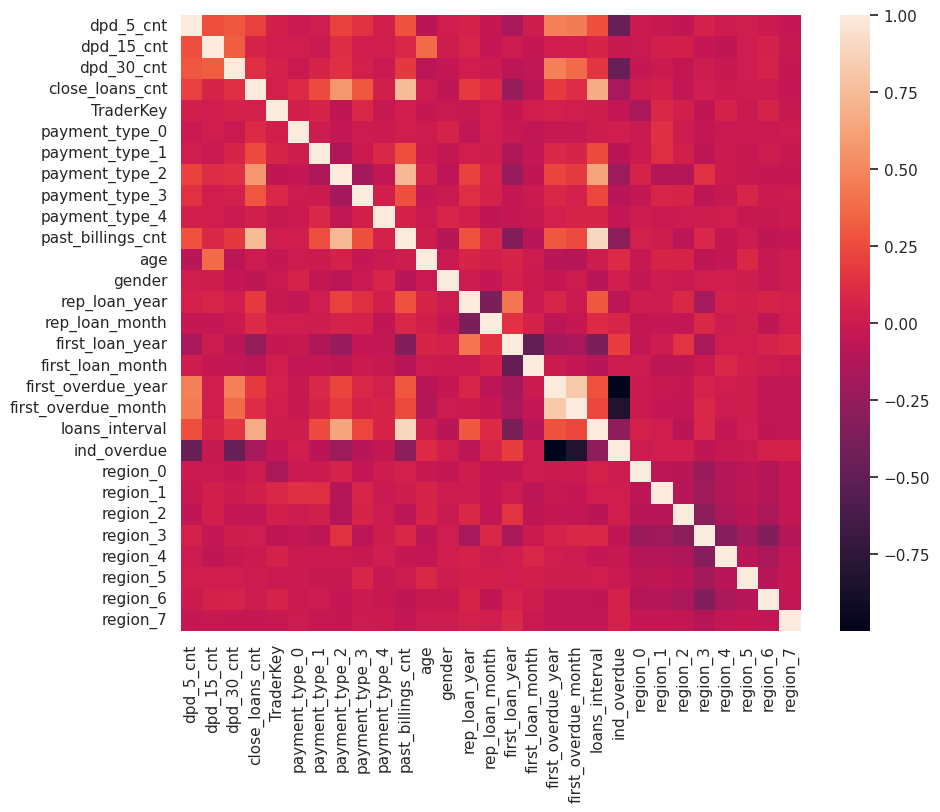

In [260]:
sns.set(rc={'figure.figsize':(10, 8)})
sns.heatmap(X.corr(), annot=False)

In [261]:
X[['past_billings_cnt', 'loans_interval']].corr()

,past_billings_cnt,loans_interval
past_billings_cnt,1.000000,0.897823
loans_interval,0.897823,1.000000


In [262]:
# удаляем признак past_billings_cnt из-за высокой корреляции с loan_interval
X = X.drop('past_billings_cnt', axis=1)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [264]:
print(f'Размер обучающей выборки: {X_train.shape, y_train.shape}')
print(f'Размер тестовой выборки:  {X_test.shape, y_test.shape}')

Размер обучающей выборки: ((5596, 28), (5596,))
Размер тестовой выборки:  ((1866, 28), (1866,))


In [265]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Обучение моделей

### Логистическая регрессия

In [266]:
lr = LogisticRegression(solver='newton-cholesky', max_iter=500)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

lr_acc = accuracy_score(y_pred_lr, y_test)
lr_f1 = f1_score(y_test, y_pred_lr, average='binary')
lr_f2 = fbeta_score(y_test, y_pred_lr, beta=2)     # для данной задачи субъективно recall важнее, чем precision
print("Точность модели (accuracy): ", round(lr_acc*100, 2), "%")
print("Точность модели (F1-score): ", round(lr_f1, 3))
print("Точность модели (F2-score): ", round(lr_f2, 3))
print("------------------------------")
acc_train = round(accuracy_score(lr.predict(X_train), y_train)*100, 2)
print("Точность на обучающей выборке (accuracy): ", acc_train, "%")
if lr_acc*0.9 <= acc_train/100 <= lr_acc*1.1:
    print("Недообучения/переобучения модели не выявлено")
else:
    print("Выявлено недообучение/переобучение модели!")

Точность модели (accuracy):  67.15 %
Точность модели (F1-score):  0.677
Точность модели (F2-score):  0.682
------------------------------
Точность на обучающей выборке (accuracy):  67.85 %
Недообучения/переобучения модели не выявлено


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

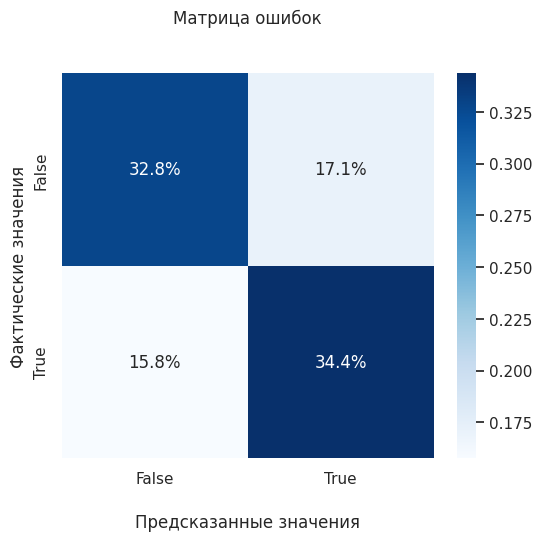

In [267]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.rcParams['figure.figsize'] = (6,5)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [268]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.68      0.66      0.67       931
           1       0.67      0.69      0.68       935

    accuracy                           0.67      1866
   macro avg       0.67      0.67      0.67      1866
weighted avg       0.67      0.67      0.67      1866



In [269]:
results = model_selection.cross_val_score(lr, X_train, y_train, cv=7, scoring='accuracy')
lr_cv_acc = round(results.mean()* 100, 1)
print(f'Accuracy при кросс-валидации на 7 фолдах:  {lr_cv_acc} %')

results = model_selection.cross_val_score(lr, X_train, y_train, cv=7, scoring='f1')
lr_f1_cv = round(results.mean(), 3)
print(f'F1 при кросс-валидации на 7 фолдах:  {lr_f1_cv}')

Accuracy при кросс-валидации на 7 фолдах:  67.5 %
F1 при кросс-валидации на 7 фолдах:  0.676


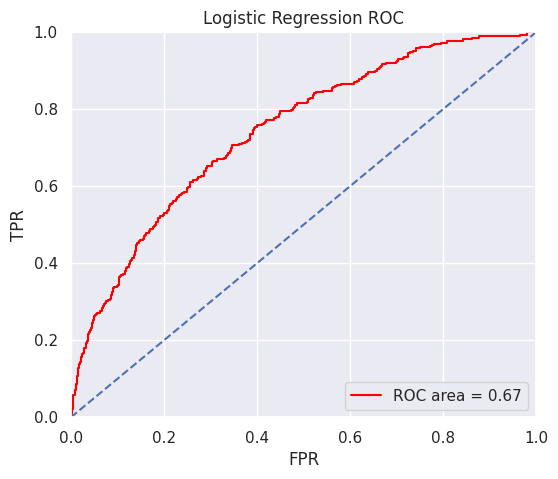

In [270]:
lr_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label=f'ROC area = {round(lr_roc_auc, 2)}', color='red')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Logistic Regression ROC')
plt.legend(loc="lower right")
plt.show()

### Метод опорных векторов

In [271]:
SVC = SVC(kernel='poly', degree=7, probability=True)
SVC.fit(X_train, y_train)
y_pred_SVC = SVC.predict(X_test)

SVC_acc = accuracy_score(y_pred_SVC, y_test)
SVC_f1 = f1_score(y_test, y_pred_SVC, average='binary')
SVC_f2 = fbeta_score(y_test, y_pred_SVC, beta=2)     # для данной задачи субъективно recall важнее, чем precision
print("Точность модели (accuracy): ", round(SVC_acc*100, 2), "%")
print("Точность модели (F1-score): ", round(SVC_f1, 3))
print("Точность модели (F2-score): ", round(SVC_f2, 3))
print("------------------------------")
acc_train = round(accuracy_score(SVC.predict(X_train), y_train)*100, 2)
print("Точность на обучающей выборке (accuracy): ", acc_train, "%")
if SVC_acc*0.9 <= acc_train/100 <= SVC_acc*1.1:
    print("Недообучения/переобучения модели не выявлено")
else:
    print("Выявлено недообучение/переобучение модели!")

Точность модели (accuracy):  80.06 %
Точность модели (F1-score):  0.813
Точность модели (F2-score):  0.842
------------------------------
Точность на обучающей выборке (accuracy):  84.61 %
Недообучения/переобучения модели не выявлено


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

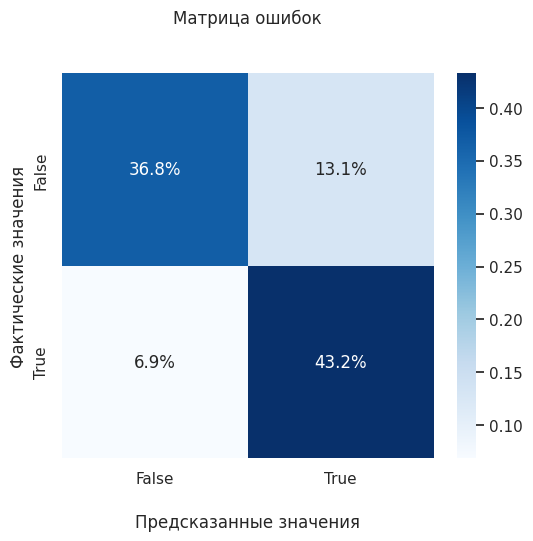

In [272]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_SVC)
plt.rcParams['figure.figsize'] = (6,5)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [273]:
print(classification_report(y_test, y_pred_SVC))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79       931
           1       0.77      0.86      0.81       935

    accuracy                           0.80      1866
   macro avg       0.81      0.80      0.80      1866
weighted avg       0.81      0.80      0.80      1866



In [274]:
results = model_selection.cross_val_score(SVC, X_train, y_train, cv=7, scoring='accuracy')
SVC_cv_acc = round(results.mean()* 100, 1)
print(f'Accuracy при кросс-валидации на 7 фолдах:  {SVC_cv_acc} %')

results = model_selection.cross_val_score(SVC, X_train, y_train, cv=7, scoring='f1')
SVC_f1_cv = round(results.mean(), 3)
print(f'F1 при кросс-валидации на 7 фолдах:  {SVC_f1_cv}')

Accuracy при кросс-валидации на 7 фолдах:  80.7 %
F1 при кросс-валидации на 7 фолдах:  0.816


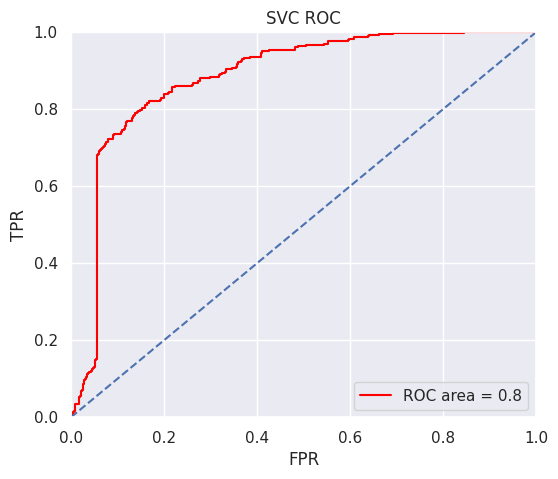

In [275]:
SVC_roc_auc = roc_auc_score(y_test, SVC.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, SVC.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label=f'ROC area = {round(SVC_roc_auc, 2)}', color='red')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('SVC ROC')
plt.legend(loc="lower right")
plt.show()

### Метод K ближайших соседей

In [276]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(X_train, y_train)
y_pred_KNN = KNN.predict(X_test)

KNN_acc = accuracy_score(y_pred_KNN, y_test)
KNN_f1 = f1_score(y_test, y_pred_KNN, average='binary')
KNN_f2 = fbeta_score(y_test, y_pred_KNN, beta=2)
print("Точность модели (accuracy): ", round(KNN_acc*100, 2), "%")
print("Точность модели (F1-score): ", round(KNN_f1, 3))
print("Точность модели (F2-score): ", round(KNN_f2, 3))
print("------------------------------")
acc_train = round(accuracy_score(KNN.predict(X_train), y_train)*100, 2)
print("Точность на обучающей выборке (accuracy): ", acc_train, "%")
if KNN_acc*0.9 <= acc_train/100 <= KNN_acc*1.1:
    print("Недообучения/переобучения модели не выявлено")
else:
    print("Выявлено недообучение/переобучение модели!")

Точность модели (accuracy):  89.23 %
Точность модели (F1-score):  0.903
Точность модели (F2-score):  0.958
------------------------------
Точность на обучающей выборке (accuracy):  94.62 %
Недообучения/переобучения модели не выявлено


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

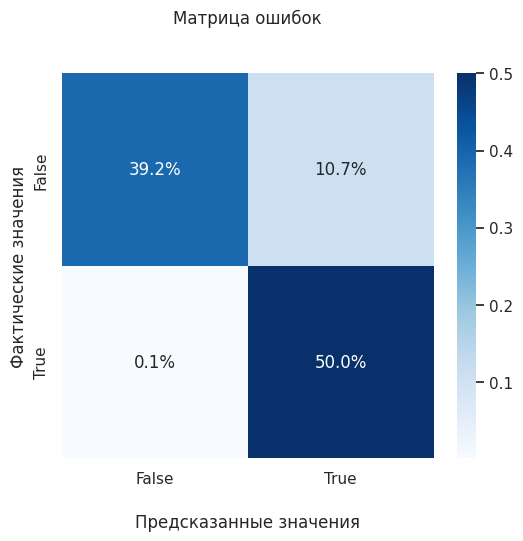

In [277]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_KNN)
plt.rcParams['figure.figsize'] = (6,5)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [278]:
print(classification_report(y_test, y_pred_KNN))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88       931
           1       0.82      1.00      0.90       935

    accuracy                           0.89      1866
   macro avg       0.91      0.89      0.89      1866
weighted avg       0.91      0.89      0.89      1866



In [279]:
results = model_selection.cross_val_score(KNN, X_train, y_train, cv=7, scoring='accuracy')
KNN_cv_acc = round(results.mean()* 100, 1)
print(f'Accuracy при кросс-валидации на 7 фолдах:  {KNN_cv_acc} %')

results = model_selection.cross_val_score(KNN, X_train, y_train, cv=7, scoring='f1')
KNN_f1_cv = round(results.mean(), 3)
print(f'F1 при кросс-валидации на 7 фолдах:  {KNN_f1_cv}')

Accuracy при кросс-валидации на 7 фолдах:  88.4 %
F1 при кросс-валидации на 7 фолдах:  0.895


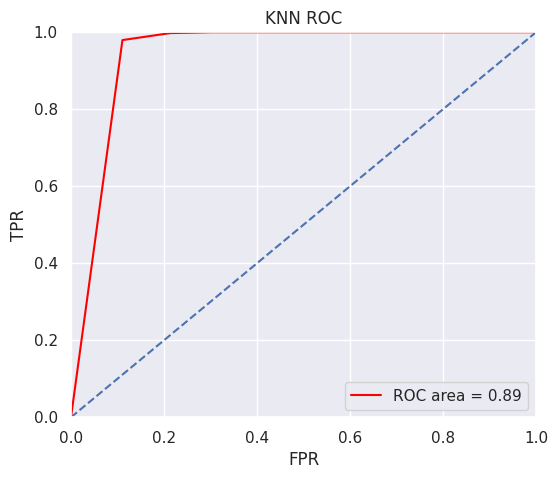

In [280]:
KNN_roc_auc = roc_auc_score(y_test, KNN.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, KNN.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label=f'ROC area = {round(KNN_roc_auc, 2)}', color='red')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('KNN ROC')
plt.legend(loc="lower right")
plt.show()

### Дерево решений

In [281]:
DTC = DecisionTreeClassifier(max_depth=15, min_samples_leaf=3)
DTC.fit(X_train, y_train)
y_pred_DTC = DTC.predict(X_test)

DTC_acc = accuracy_score(y_pred_DTC, y_test)
DTC_f1 = f1_score(y_test, y_pred_DTC, average='binary')
DTC_f2 = fbeta_score(y_test, y_pred_DTC, beta=2)
print("Точность модели (accuracy): ", round(DTC_acc*100, 2), "%")
print("Точность модели (F1-score): ", round(DTC_f1, 3))
print("Точность модели (F2-score): ", round(DTC_f2, 3))
print("------------------------------")
acc_train = round(accuracy_score(DTC.predict(X_train), y_train)*100, 2)
print("Точность на обучающей выборке (accuracy): ", acc_train, "%")
if DTC_acc*0.9 <= acc_train/100 <= DTC_acc*1.1:
    print("Недообучения/переобучения модели не выявлено")
else:
    print("Выявлено недообучение/переобучение модели!")

Точность модели (accuracy):  90.03 %
Точность модели (F1-score):  0.909
Точность модели (F2-score):  0.955
------------------------------
Точность на обучающей выборке (accuracy):  95.96 %
Недообучения/переобучения модели не выявлено


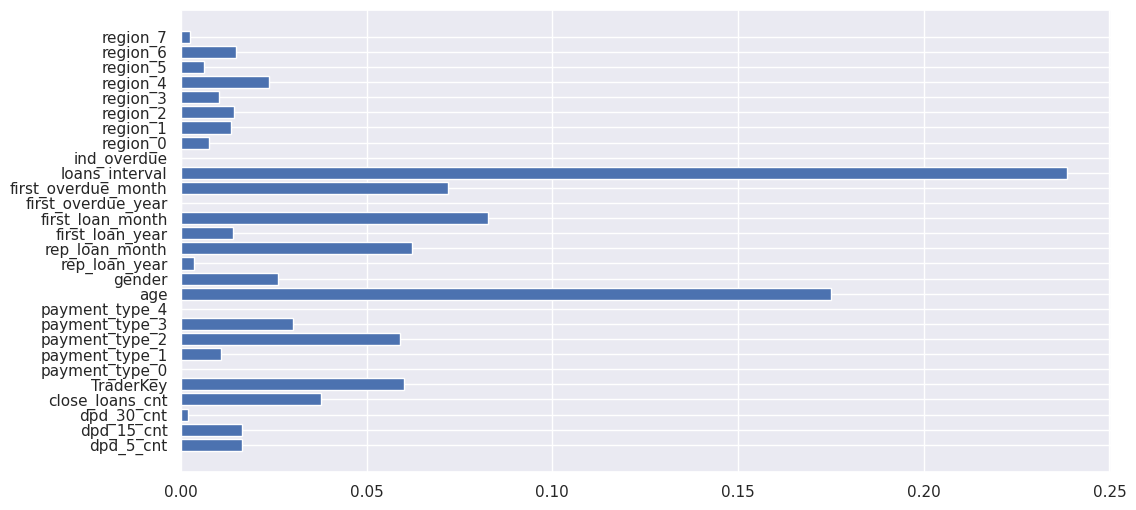

In [282]:
# оценка важности признаков
plt.figure(figsize=(12, 6))
plt.barh(np.arange(len(DTC.feature_importances_)), DTC.feature_importances_)
plt.yticks(np.arange(len(X.columns)), X.columns)
plt.show()

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

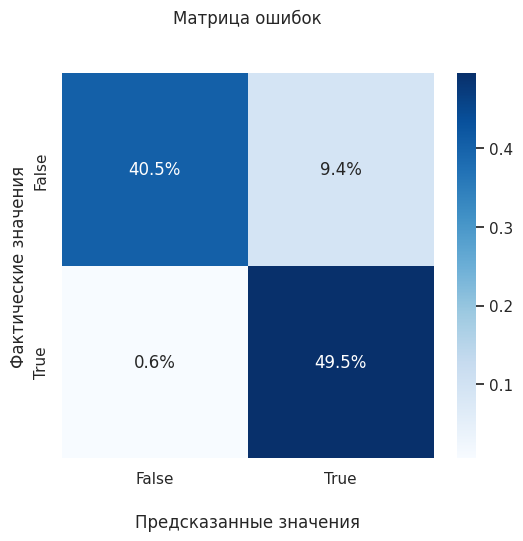

In [283]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_DTC)
plt.rcParams['figure.figsize'] = (6,5)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [284]:
print(classification_report(y_test, y_pred_DTC))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89       931
           1       0.84      0.99      0.91       935

    accuracy                           0.90      1866
   macro avg       0.91      0.90      0.90      1866
weighted avg       0.91      0.90      0.90      1866



In [285]:
results = model_selection.cross_val_score(DTC, X_train, y_train, cv=7, scoring='accuracy')
DTC_cv_acc = round(results.mean()* 100, 1)
print(f'Accuracy при кросс-валидации на 7 фолдах:  {DTC_cv_acc} %')

results = model_selection.cross_val_score(DTC, X_train, y_train, cv=7, scoring='f1')
DTC_f1_cv = round(results.mean(), 3)
print(f'F1 при кросс-валидации на 7 фолдах:  {DTC_f1_cv}')

Accuracy при кросс-валидации на 7 фолдах:  89.7 %
F1 при кросс-валидации на 7 фолдах:  0.903


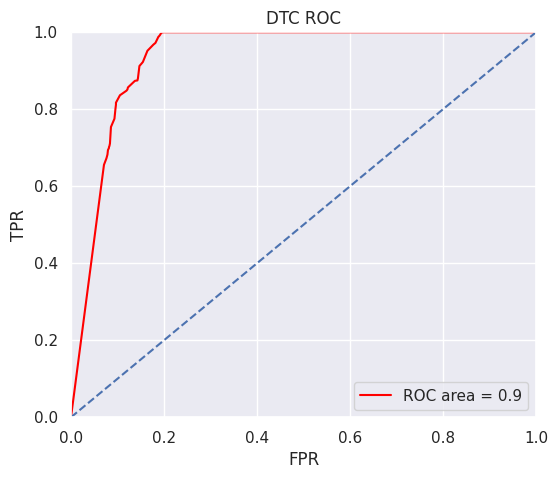

In [286]:
DTC_roc_auc = roc_auc_score(y_test, DTC.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, DTC.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label=f'ROC area = {round(DTC_roc_auc, 2)}', color='red')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('DTC ROC')
plt.legend(loc="lower right")
plt.show()

### Случайный лес

In [306]:
RFC = RandomForestClassifier(n_estimators=70, max_depth=15, min_samples_leaf=3)
RFC.fit(X_train, y_train)
y_pred_RFC = RFC.predict(X_test)

RFC_acc = accuracy_score(y_pred_RFC, y_test)
RFC_f1 = f1_score(y_test, y_pred_RFC, average='binary')
RFC_f2 = fbeta_score(y_test, y_pred_RFC, beta=2)
print("Точность модели (accuracy): ", round(RFC_acc*100, 2), "%")
print("Точность модели (F1-score): ", round(RFC_f1, 3))
print("Точность модели (F2-score): ", round(RFC_f2, 3))
print("------------------------------")
acc_train = round(accuracy_score(RFC.predict(X_train), y_train)*100, 2)
print("Точность на обучающей выборке (accuracy): ", acc_train, "%")
if RFC_acc*0.9 <= acc_train/100 <= RFC_acc*1.1:
    print("Недообучения/переобучения модели не выявлено")
else:
    print("Выявлено недообучение/переобучение модели!")

Точность модели (accuracy):  92.98 %
Точность модели (F1-score):  0.933
Точность модели (F2-score):  0.962
------------------------------
Точность на обучающей выборке (accuracy):  97.32 %
Недообучения/переобучения модели не выявлено


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

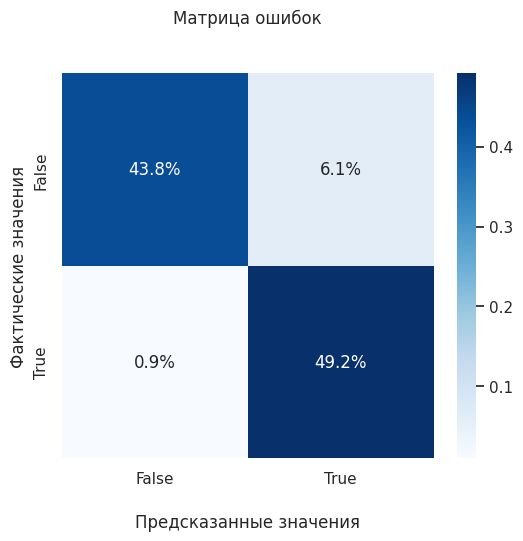

In [307]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_RFC)
plt.rcParams['figure.figsize'] = (6,5)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [308]:
print(classification_report(y_test, y_pred_RFC))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       931
           1       0.89      0.98      0.93       935

    accuracy                           0.93      1866
   macro avg       0.93      0.93      0.93      1866
weighted avg       0.93      0.93      0.93      1866



In [309]:
results = model_selection.cross_val_score(RFC, X_train, y_train, cv=7, scoring='accuracy')
RFC_cv_acc = round(results.mean()* 100, 1)
print(f'Accuracy при кросс-валидации на 7 фолдах:  {RFC_cv_acc} %')

results = model_selection.cross_val_score(RFC, X_train, y_train, cv=7, scoring='f1')
RFC_f1_cv = round(results.mean(), 3)
print(f'F1 при кросс-валидации на 7 фолдах:  {RFC_f1_cv}')

Accuracy при кросс-валидации на 7 фолдах:  92.2 %
F1 при кросс-валидации на 7 фолдах:  0.923


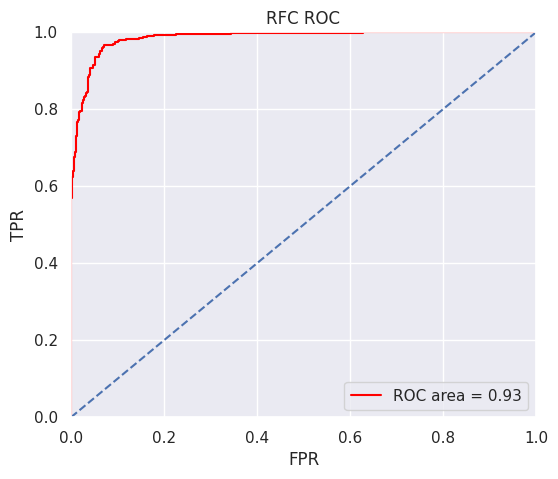

In [310]:
RFC_roc_auc = roc_auc_score(y_test, RFC.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, RFC.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label=f'ROC area = {round(RFC_roc_auc, 2)}', color='red')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('RFC ROC')
plt.legend(loc="lower right")
plt.show()

### XGBoost

In [292]:
xgb = Xgb.XGBClassifier(max_depth=5)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

xgb_acc = accuracy_score(y_pred_xgb, y_test)
xgb_f1 = f1_score(y_test, y_pred_xgb, average='binary')
xgb_f2 = fbeta_score(y_test, y_pred_xgb, beta=2)
print("Точность модели (accuracy): ", round(xgb_acc*100, 2), "%")
print("Точность модели (F1-score): ", round(xgb_f1, 3))
print("Точность модели (F2-score): ", round(xgb_f2, 3))
print("------------------------------")
acc_train = round(accuracy_score(xgb.predict(X_train), y_train)*100, 2)
print("Точность на обучающей выборке (accuracy): ", acc_train, "%")
if xgb_acc*0.9 <= acc_train/100 <= xgb_acc*1.1:
    print("Недообучения/переобучения модели не выявлено")
else:
    print("Выявлено недообучение/переобучение модели!")

Точность модели (accuracy):  92.87 %
Точность модели (F1-score):  0.932
Точность модели (F2-score):  0.961
------------------------------
Точность на обучающей выборке (accuracy):  97.69 %
Недообучения/переобучения модели не выявлено


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

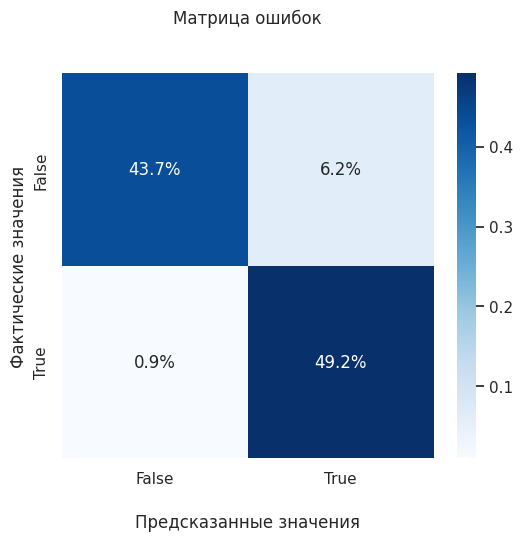

In [293]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_xgb)
plt.rcParams['figure.figsize'] = (6,5)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [294]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.88      0.92       931
           1       0.89      0.98      0.93       935

    accuracy                           0.93      1866
   macro avg       0.93      0.93      0.93      1866
weighted avg       0.93      0.93      0.93      1866



In [295]:
results = model_selection.cross_val_score(xgb, X_train, y_train, cv=7, scoring='accuracy')
xgb_cv_acc = round(results.mean()* 100, 1)
print(f'Accuracy при кросс-валидации на 7 фолдах:  {xgb_cv_acc} %')

results = model_selection.cross_val_score(xgb, X_train, y_train, cv=7, scoring='f1')
xgb_f1_cv = round(results.mean(), 3)
print(f'F1 при кросс-валидации на 7 фолдах:  {xgb_f1_cv}')

Accuracy при кросс-валидации на 7 фолдах:  92.3 %
F1 при кросс-валидации на 7 фолдах:  0.927


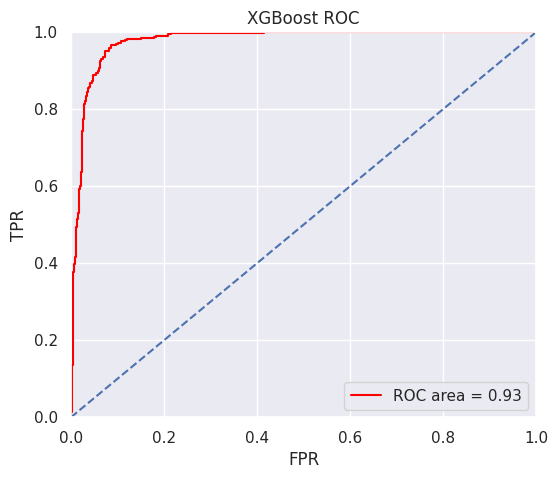

In [296]:
xgb_roc_auc = roc_auc_score(y_test, xgb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label=f'ROC area = {round(xgb_roc_auc, 2)}', color='red')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('XGBoost ROC')
plt.legend(loc="lower right")
plt.show()

## Сводное сравнение обученных моделей

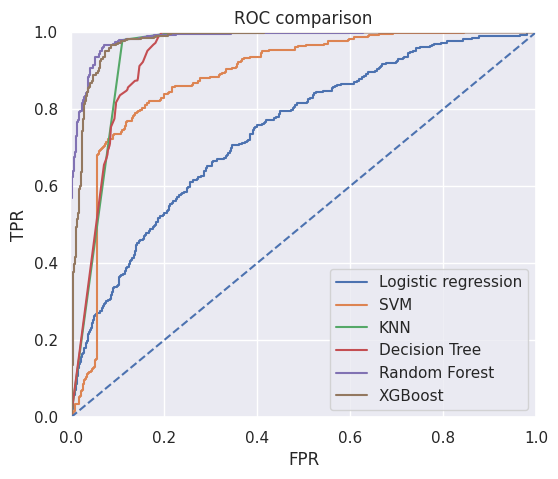

In [311]:
# Визуализация ROC-характеристик

plt.figure(0).clf()

fpr1, tpr1, thresholds1 = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
auc1 = roc_auc_score(y_test, lr.predict(X_test))
plt.plot(fpr1, tpr1, label="Logistic regression")

fpr2, tpr2, thresholds2 = roc_curve(y_test, SVC.predict_proba(X_test)[:,1])
auc1 = roc_auc_score(y_test, SVC.predict(X_test))
plt.plot(fpr2, tpr2, label="SVM")

fpr3, tpr3, thresholds3 = roc_curve(y_test, KNN.predict_proba(X_test)[:,1])
auc1 = roc_auc_score(y_test, KNN.predict(X_test))
plt.plot(fpr3, tpr3, label="KNN")

fpr4, tpr4, thresholds4 = roc_curve(y_test, DTC.predict_proba(X_test)[:,1])
auc1 = roc_auc_score(y_test, DTC.predict(X_test))
plt.plot(fpr4, tpr4, label="Decision Tree")

fpr5, tpr5, thresholds5 = roc_curve(y_test, RFC.predict_proba(X_test)[:,1])
auc1 = roc_auc_score(y_test, RFC.predict(X_test))
plt.plot(fpr5, tpr5, label="Random Forest")

fpr5, tpr5, thresholds5 = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
auc1 = roc_auc_score(y_test, xgb.predict(X_test))
plt.plot(fpr5, tpr5, label="XGBoost")

plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC comparison')
plt.legend(loc="lower right")
plt.show()

In [312]:
# создание итогового датафрейма с показателями точности моделей
df_models_acc = pd.DataFrame([lr_cv_acc, SVC_cv_acc, KNN_cv_acc, DTC_cv_acc, RFC_cv_acc, xgb_cv_acc], columns=['Accuracy (%)'])
df_models_f1 = pd.DataFrame([lr_f1_cv, SVC_f1_cv, KNN_f1_cv, DTC_f1_cv, RFC_f1_cv, xgb_f1_cv], columns=['F1-score'])
df_models_f5 = pd.DataFrame([lr_f2, SVC_f2, KNN_f2, DTC_f2, RFC_f2, xgb_f2], columns=['F2-score'])
df_models_names = pd.DataFrame(['Logistic regression', 'SVM', 'KNN', 'Decision tree', 'Random Forest', 'XGBoost'], columns=['Модель'])
df_comparison = pd.concat([df_models_names, df_models_acc, df_models_f1, df_models_f5], axis=1).sort_values(by='F1-score', ascending=False)

df_comparison.style.bar(cmap='Greens', align='mid', vmin=0., vmax=1.).hide_index()

Модель,Accuracy (%),F1-score,F2-score
XGBoost,92.300000,0.927000,0.961458
Random Forest,92.200000,0.923000,0.961861
Decision tree,89.700000,0.903000,0.954743
KNN,88.400000,0.895000,0.957512
SVM,80.700000,0.816000,0.842204
Logistic regression,67.500000,0.676000,0.681915


**ВЫВОДЫ:**
- при использовании классических методов ML, наиболее эффективными оказались модели RandomForest и XGBoost
- с учетом бизнес-рисков, важной метрикой является F2-score (минимизация ложноотрицатнльных предсказаний)
- высокие метрики показали модели DecisionTree и KNN (с kernel trick), в т.ч. по метрике F2-score
- модели Опорных векторов и, особенно, Логистической регрессии имеют неудовлетворительные метрики
- недообученности / переобученности моделей не зафиксировано

## Беггинг (на базе KNN)

In [313]:
bagging = BaggingClassifier(KNN)
bagging.fit(X_train, y_train)

BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3))

In [314]:
y_pred_bag_KNN = bagging.predict(X_test)

bag_knn_acc = accuracy_score(y_pred_bag_KNN, y_test)
bag_knn_f1 = f1_score(y_test, y_pred_bag_KNN, average='binary')
bag_knn_f2 = fbeta_score(y_test, y_pred_bag_KNN, beta=2)
print("Точность модели (accuracy): ", round(bag_knn_acc*100, 2), "%")
print("Точность модели (F1-score): ", round(bag_knn_f1, 3))
print("Точность модели (F2-score): ", round(bag_knn_f2, 3))

Точность модели (accuracy):  89.01 %
Точность модели (F1-score):  0.901
Точность модели (F2-score):  0.956


**Вывод:**
- с помощью беггинга удалось повысить отдельные метрики модели KNN, но они не достигли уровня 3 лучших моделей

## Стекинг (LogReg+KNN+DecisionTree)

In [315]:
stacking_clf = StackingClassifier(
    [
        ('LinearRegression', lr),
        ('KNeighborsRegressor', KNN),
        ('DecisionTree', DTC)
    ], DTC)

In [316]:
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('LinearRegression',
                                LogisticRegression(max_iter=500,
                                                   solver='newton-cholesky')),
                               ('KNeighborsRegressor',
                                KNeighborsClassifier(n_neighbors=3)),
                               ('DecisionTree',
                                DecisionTreeClassifier(max_depth=15,
                                                       min_samples_leaf=3))],
                   final_estimator=DecisionTreeClassifier(max_depth=15,
                                                          min_samples_leaf=3))

In [317]:
y_pred_stacking = stacking_clf.predict(X_test)

stacking_acc = accuracy_score(y_pred_stacking, y_test)
stacking_f1 = f1_score(y_test, y_pred_stacking, average='binary')
stacking_f2 = fbeta_score(y_test, y_pred_stacking, beta=2)
print("Точность модели (accuracy): ", round(stacking_acc*100, 2), "%")
print("Точность модели (F1-score): ", round(stacking_f1, 3))
print("Точность модели (F2-score): ", round(stacking_f2, 3))

Точность модели (accuracy):  94.37 %
Точность модели (F1-score):  0.944
Точность модели (F2-score):  0.94


**Вывод:**
- с помощью стекинга удалось получить ансамблевую модель с метриками accuracy и f1-score, превосходящими модели RandomForest и XGBoost
- однако метрика f2-score по результатам стекинга хуже, чем в указанных моделях

## Поиск наилучших гиперпараметров модели RandomForest (RandomizedSearchCV)

In [ ]:
params = {'max_depth': [7, 10, 13, 17, 20],
          'n_estimators': [20, 50, 100, 150, 200],
          'max_features': ['int', 'sqrt', 'log2'],
          'criterion': ['gini', 'entropy', 'log_loss'],
          'min_samples_leaf': [1, 2, 4, 7],
          'min_samples_split': [2, 4, 7, 10]
         }
RFC_random = RandomizedSearchCV(RFC, params, n_iter=500, scoring='f1', n_jobs=-1, cv=3)
model_1_random = RFC_random.fit(X,y)

In [ ]:
print(f'Лучшие подобранные гиперпараметры модели RandomForest:  {model_1_random.best_params_}')
print(f'F1-score при указанных параметрах:  {round(model_1_random.best_score_, 3)}')

Лучшие подобранные гиперпараметры модели RandomForest:  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}
F1-score при указанных параметрах:  0.973


In [318]:
# обучение модели с подобранными параметрами, оценка комплекса метрик
RFC_upd = RandomForestClassifier(n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20, criterion='gini')
RFC_upd.fit(X_train, y_train)
y_pred_RFC_upd = RFC_upd.predict(X_test)

RFC_upd_acc = accuracy_score(y_pred_RFC_upd, y_test)*100
RFC_upd_f1 = f1_score(y_test, y_pred_RFC_upd, average='binary')
RFC_upd_f2 = fbeta_score(y_test, y_pred_RFC_upd, beta=2)
print("Точность модели (accuracy): ", round(RFC_upd_acc, 2), "%")
print("Точность модели (F1-score): ", round(RFC_upd_f1, 3))
print("Точность модели (F2-score): ", round(RFC_upd_f2, 3))

Точность модели (accuracy):  97.16 %
Точность модели (F1-score):  0.972
Точность модели (F2-score):  0.989


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

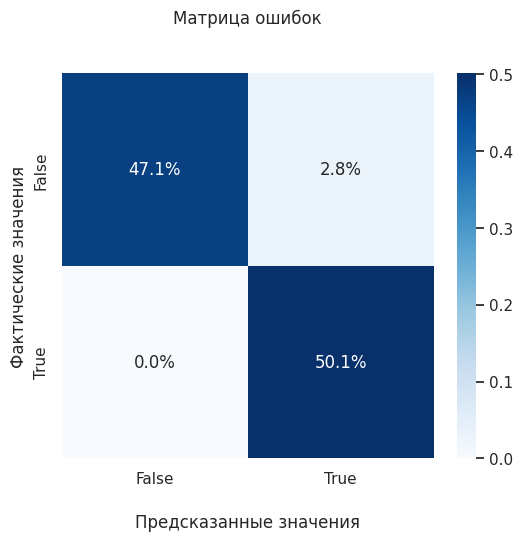

In [330]:
# Визуализация матрицы ошибок
cf_matrix = confusion_matrix(y_test, y_pred_RFC_upd)
plt.rcParams['figure.figsize'] = (6,5)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.1%', cmap='Blues')
ax.set_title('Матрица ошибок\n\n');
ax.set_xlabel('\nПредсказанные значения')
ax.set_ylabel('Фактические значения')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [332]:
print(classification_report(y_test, y_pred_RFC_upd))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       931
           1       0.95      1.00      0.97       935

    accuracy                           0.97      1866
   macro avg       0.97      0.97      0.97      1866
weighted avg       0.97      0.97      0.97      1866



In [333]:
results = model_selection.cross_val_score(RFC_upd, X_train, y_train, cv=7, scoring='accuracy')
RFC_upd_cv_acc = round(results.mean()* 100, 1)
print(f'Accuracy при кросс-валидации на 7 фолдах:  {RFC_upd_cv_acc} %')

results = model_selection.cross_val_score(RFC_upd, X_train, y_train, cv=7, scoring='f1')
RFC_upd_f1_cv = round(results.mean(), 3)
print(f'F1 при кросс-валидации на 7 фолдах:  {RFC_upd_f1_cv}')

Accuracy при кросс-валидации на 7 фолдах:  97.1 %
F1 при кросс-валидации на 7 фолдах:  0.972


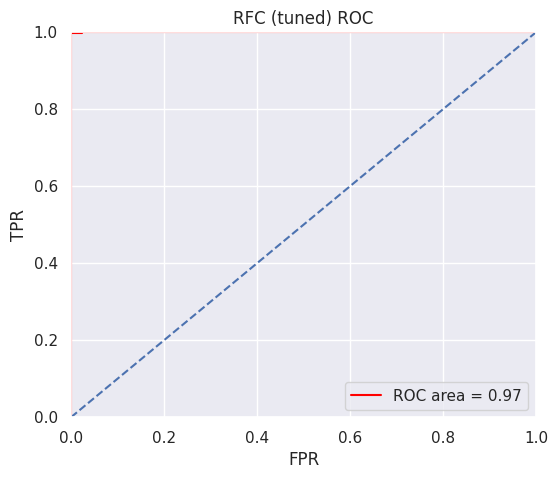

In [335]:
RFC_upd_roc_auc = roc_auc_score(y_test, RFC_upd.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, RFC_upd.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label=f'ROC area = {round(RFC_upd_roc_auc, 2)}', color='red')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('RFC (tuned) ROC')
plt.legend(loc="lower right")
plt.show()

## Нейронная сеть

In [319]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test.to_numpy())

In [320]:
class NeuralNet(nn.Module):

    def __init__(self, in_features=28, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=112)
        self.fc2 = nn.Linear(in_features=112,
                             out_features=56)
        self.fc3 = nn.Linear(in_features=56,
                             out_features=out_features)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return self.fc3(X)

In [321]:
model = NeuralNet()

In [322]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [326]:
epochs = 350
losses = []
for i in range(epochs):
    i += 1

    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    losses.append(loss)

    if i % 10 == 0:
        print(f'epoch: {i} -> loss: {loss}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 10 -> loss: 0.1546436995267868
epoch: 20 -> loss: 0.15129756927490234
epoch: 30 -> loss: 0.144338920712471
epoch: 40 -> loss: 0.14168725907802582
epoch: 50 -> loss: 0.137051522731781
epoch: 60 -> loss: 0.1366482377052307
epoch: 70 -> loss: 0.13229362666606903
epoch: 80 -> loss: 0.12693141400814056
epoch: 90 -> loss: 0.12514279782772064
epoch: 100 -> loss: 0.12268933653831482
epoch: 110 -> loss: 0.1186872124671936
epoch: 120 -> loss: 0.12337328493595123
epoch: 130 -> loss: 0.11624214053153992
epoch: 140 -> loss: 0.11221804469823837
epoch: 150 -> loss: 0.11277065426111221
epoch: 160 -> loss: 0.10751951485872269
epoch: 170 -> loss: 0.11152041703462601
epoch: 180 -> loss: 0.10216977447271347
epoch: 190 -> loss: 0.1004522368311882
epoch: 200 -> loss: 0.10522394627332687
epoch: 210 -> loss: 0.10618656873703003
epoch: 220 -> loss: 0.09816011786460876
epoch: 230 -> loss: 0.10925998538732529
epoch: 240 -> loss: 0.09555060416460037
epoch: 250 -> loss: 0.09628079831600189
epoch: 260 -> los

In [327]:
with torch.no_grad():

    y_pred = model(X_test)
    preds = torch.max(y_pred, dim=1)[1]
    correct = (preds == y_test).sum()
    accuracy_nn = correct.item() / y_test.shape[0] * 100

print("Точность модели (accuracy): ", round(accuracy_nn, 2), "%")

Точность модели (accuracy):  91.1 %


In [328]:
with torch.no_grad():

    y_pred = model(X_test)
    preds = torch.max(y_pred, dim=1)[1]
    TP = ((preds == y_test)&(y_test == 1)).sum()
    FP = ((preds != y_test)&(y_test == 0)).sum()
    precision = TP / (TP + FP)
    FN = ((preds != y_test)&(y_test == 1)).sum()
    recall = TP / (TP + FN)
    F1_nn = float(2*precision*recall / (precision + recall))
    F2_nn = float(5*precision*recall / (4*precision + recall))

print("Точность модели (F1-score): ", round(F1_nn, 3))
print("Точность модели (F2-score): ", round(F2_nn, 3))

Точность модели (F1-score):  0.917
Точность модели (F2-score):  0.957


## ВЫВОДЫ

In [337]:
# создание дополненного итогового датафрейма с показателями точности моделей
df_models_acc = pd.DataFrame([lr_cv_acc, SVC_cv_acc, KNN_cv_acc, DTC_cv_acc, RFC_cv_acc, xgb_cv_acc, RFC_upd_cv_acc, accuracy_nn], columns=['Accuracy (%)'])
df_models_f1 = pd.DataFrame([lr_f1_cv, SVC_f1_cv, KNN_f1_cv, DTC_f1_cv, RFC_f1_cv, xgb_f1_cv, RFC_upd_f1_cv, F1_nn], columns=['F1-score'])
df_models_f5 = pd.DataFrame([lr_f2, SVC_f2, KNN_f2, DTC_f2, RFC_f2, xgb_f2, RFC_upd_f2, F2_nn], columns=['F2-score'])
df_models_names = pd.DataFrame(['Logistic regression', 'SVM', 'KNN', 'Decision tree', 'Random Forest', 'XGBoost', 'Random Forest (tuned)', 'Neural network'], columns=['Модель'])
df_comparison = pd.concat([df_models_names, df_models_acc, df_models_f1, df_models_f5], axis=1).sort_values(by='F1-score', ascending=False)

df_comparison.style.bar(cmap='Greens', align='mid', vmin=0., vmax=1.).hide_index()

Модель,Accuracy (%),F1-score,F2-score
Random Forest (tuned),97.100000,0.972000,0.988790
XGBoost,92.300000,0.927000,0.961458
Random Forest,92.200000,0.923000,0.961861
Neural network,91.103966,0.917331,0.956784
Decision tree,89.700000,0.903000,0.954743
KNN,88.400000,0.895000,0.957512
SVM,80.700000,0.816000,0.842204
Logistic regression,67.500000,0.676000,0.681915


По итогам исследования:
- наилучшие метрики получены на модели Random Forest (с подобранными оптимальными гиперпараметрами)
- все 3 метрики указанной модели - выше 0.97
- при оценке метрик учитывалась бизнес-задача с минимизацией ложно положительных предсказаний (F2-score)
- относительно высокие метрики - также у моделей XGBoost, DecisionTree, KNN и полносвязной нейронной сети, а также по результатам беггинга и стекинга
- метрики моделей Логистической регрессии и Опорных векторов - неудовлетворительные
